In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Wyoming
state_ab = "wy"

## Data
1. Download all the data in directory "tn_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
send_data = "./{}{}_sldu_adopted_2022/HB0100_HEA0062_SDFinal_20220314.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/HB0100_HEA0062_HDFinal_20220314.shp".format(data_folder, state_ab)
county_data = "./{}{}_cvap_2022_cnty/{}_cvap_2022_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)
    
    # check maup doctor again to see if smart repair works
    if maup.doctor(df) == True:
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        df = df.to_crs('EPSG:4269')
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs('EPSG:4269')
    dist_df = dist_df.to_crs('EPSG:4269')
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col):
    df = df.to_crs('EPSG:4269')
    vest = vest.to_crs('EPSG:4269')
    population = population.to_crs('EPSG:4269')
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = "EPSG:4269")
    # check if population agrees
    check_population(population, df)
    
    return df

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [16]:
maup.doctor(population_df)

100%|███████████████████████████████████| 53769/53769 [00:29<00:00, 1798.69it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [21]:
maup.doctor(county_df)

100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1518.96it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

In [23]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs('EPSG:4269')
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")

    vest = vest.to_crs(vest.estimate_utm_crs())
    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
   
    vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision)
    
    return vest

## Check if vest20 can be used as base

In [25]:
vest20 = gpd.read_file(vest20_data)

In [26]:
vest20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'NAME20', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREIPIE', 'G20PREOWRI', 'G20USSRLUM',
       'G20USSDDAV', 'G20USSOWRI', 'G20HALRCHE', 'G20HALDBUL', 'G20HALLBRU',
       'G20HALCHAG', 'G20HALOWRI', 'geometry'],
      dtype='object')

In [27]:
start_col = 4
vest_base_data = vest20
year = '20'

In [28]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1375.93it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 137.74it/s]


Identifying overlaps...


100%|█████████████████████████████████████| 6814/6814 [00:03<00:00, 2008.21it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 0: 100%|█████████████| 41/41 [00:00<00:00, 56.82it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 13: 100%|███████████| 85/85 [00:00<00:00, 112.38it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 15: 100%|██████████| 157/157 [00:01<00:00, 91.92it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 22: 100%|████████████| 20/20 [00:00<00:00, 47.37it/s]
Gaps to fill: 0it [00:00, ?it/s]


In [29]:
maup.doctor(vest_base)

100%|████████████████████████████████████████| 481/481 [00:00<00:00, 650.82it/s]


True

In [30]:
this_crs = vest_base.crs
if "proj=utm" not in this_crs.to_proj4(): # should have been put in crs utm, which is in meters
    print("Error!")

boundaries = vest_base.copy() 
boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

# compute shared border length using intersection
borders = list(neighbors.apply(
    lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
))

borders.sort()

In [31]:
print(borders[:300])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1537292570887616, 2.1537292570887616, 7.777018460494129, 7.777018460494129, 9.461194491784923, 9.461194491784923, 12.232428502377925, 12.232428502377925, 14.33289573941612, 14.33289573941612, 26.831087560783395, 26.831087560783395, 28.49594379146209, 28.49594379146209, 28.849242162163648, 28.849242162163648, 29.216872683240556, 29.21687268324055

In [32]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 667/667 [00:00<00:00, 2696.33it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|████████████████████████████████████████| 481/481 [00:00<00:00, 703.18it/s]


In [33]:
maup.doctor(vest_base)

GEOSException: TopologyException: side location conflict at -108.29616606126318 45.000172480885453. This can occur if the input geometry is invalid.

Try again, adding min rook length when we fit to counties:

In [53]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df, min_rook_length = 30.5)

100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1640.04it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 160.28it/s]


Identifying overlaps...


100%|█████████████████████████████████████| 6814/6814 [00:03<00:00, 2236.20it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 0: 100%|█████████████| 41/41 [00:00<00:00, 54.69it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 13: 100%|███████████| 85/85 [00:00<00:00, 114.33it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 15: 100%|██████████| 157/157 [00:01<00:00, 94.55it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 22: 100%|████████████| 20/20 [00:00<00:00, 44.28it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 3537.51it/s]


In [54]:
maup.doctor(vest_base)

100%|████████████████████████████████████████| 481/481 [00:00<00:00, 633.13it/s]


True

In [55]:
vest_base = vest_base.to_crs('EPSG:4269')
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

 38%|███████████████▋                         | 184/481 [00:02<00:03, 88.65it/s]


GEOSException: TopologyException: side location conflict at -108.29616606126318 45.000172480885453. This can occur if the input geometry is invalid.

Try again:

In [58]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df, min_rook_length = 30.5, snap_precision = 8)

100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1402.53it/s]


Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 148.34it/s]


Identifying overlaps...


100%|█████████████████████████████████████| 6818/6818 [00:03<00:00, 1899.36it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 0: 100%|█████████████| 40/40 [00:00<00:00, 55.31it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 13: 100%|████████████| 85/85 [00:00<00:00, 97.09it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 15: 100%|██████████| 157/157 [00:01<00:00, 91.81it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 22: 100%|████████████| 21/21 [00:00<00:00, 46.86it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 3461.60it/s]


In [59]:
maup.doctor(vest_base)

100%|████████████████████████████████████████| 481/481 [00:00<00:00, 660.06it/s]


True

In [60]:
vest_base = vest_base.to_crs('EPSG:4269')
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

 38%|███████████████▎                        | 184/481 [00:01<00:02, 108.93it/s]


GEOSException: TopologyException: side location conflict at -108.29615739455946 45.000172501550544. This can occur if the input geometry is invalid.

Try without min_rook_length:

In [63]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1420.63it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 153.27it/s]


Identifying overlaps...


100%|█████████████████████████████████████| 6814/6814 [00:03<00:00, 2154.69it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 0: 100%|█████████████| 41/41 [00:01<00:00, 40.82it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 13: 100%|███████████| 85/85 [00:00<00:00, 104.93it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 15: 100%|██████████| 157/157 [00:02<00:00, 77.68it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 22: 100%|████████████| 20/20 [00:00<00:00, 44.33it/s]
Gaps to fill: 0it [00:00, ?it/s]


In [64]:
maup.doctor(vest_base)

100%|████████████████████████████████████████| 481/481 [00:00<00:00, 662.69it/s]


True

In [65]:
vest_base = vest_base.to_crs('EPSG:4269')
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

 38%|███████████████▎                        | 184/481 [00:01<00:02, 111.48it/s]


GEOSException: TopologyException: side location conflict at -108.29616606126318 45.000172480885453. This can occur if the input geometry is invalid.

One last time, try without nesting in counties:

In [68]:
vest_base = add_vest_base(vest_base_data, start_col, year, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2534/2534 [00:00<00:00, 3188.46it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to fill: 100%|███████████████████████████████| 3/3 [00:00<00:00,  8.87it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 3424.39it/s]


In [69]:
maup.doctor(vest_base)

100%|████████████████████████████████████████| 481/481 [00:00<00:00, 589.18it/s]


True

In [70]:
vest_base = vest_base.to_crs('EPSG:4269')
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|█████████████████████████████████████████| 481/481 [00:06<00:00, 77.33it/s]


## If it is true for maup doctor, we will use it as the base vest data.

In [80]:
# vap and population have the same GEOID20
vest_base = vest_base.to_crs('EPSG:4269')
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|█████████████████████████████████████████| 481/481 [00:05<00:00, 84.54it/s]


In [81]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [82]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

In [83]:
election_df.columns

Index(['COUNTYFP20', 'HAL20D', 'HAL20O', 'HAL20R', 'NAME20', 'PRE20D',
       'PRE20O', 'PRE20R', 'STATEFP20', 'USS20D', 'USS20O', 'USS20R',
       'VTDST20', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK',
       'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE',
       'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP',
       'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [85]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [87]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [88]:
vest18.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'NAME20', 'G18USSRBAR',
       'G18USSDTRA', 'G18USSLPOR', 'G18USSOWRI', 'G18HALRCHE', 'G18HALDHUN',
       'G18HALLBRU', 'G18HALCCUM', 'G18HALOWRI', 'G18GOVRGOR', 'G18GOVDTHR',
       'G18GOVLSTR', 'G18GOVCRAM', 'G18GOVOWRI', 'G18SOSRBUC', 'G18SOSDBYR',
       'G18SOSLCAR', 'G18SOSOWRI', 'G18AUDRRAC', 'G18AUDDDOC', 'G18AUDOWRI',
       'G18TRERMEI', 'G18TREDLOW', 'G18TREOWRI', 'G18SPIRBAL', 'G18SPIOWRI',
       'geometry'],
      dtype='object')

In [89]:
vest16.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'NAME20', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PRECCAS', 'G16PREIFUE', 'G16PREGSTE',
       'G16PREOWRI', 'G16HALRCHE', 'G16HALDGRE', 'G16HALLSTR', 'G16HALCCUM',
       'G16HALOWRI', 'geometry'],
      dtype='object')

In [90]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|████████████████████████████████████████| 483/483 [00:00<00:00, 607.44it/s]


There are 51 overlaps.
There are 798 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2538/2538 [00:00<00:00, 2845.17it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|█████████████████████████████████████████| 481/481 [00:06<00:00, 79.45it/s]


population agrees


In [91]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'AUD18D', 'AUD18O', 'AUD18R', 'BVAP',
       'COUNTYFP20', 'GOV18D', 'GOV18O', 'GOV18R', 'HAL18D', 'HAL18O',
       'HAL18R', 'HAL20D', 'HAL20O', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'NAME20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK',
       'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE20D', 'PRE20O',
       'PRE20R', 'SOS18D', 'SOS18O', 'SOS18R', 'SPI18O', 'SPI18R', 'STATEFP20',
       'TOTPOP', 'TRE18D', 'TRE18O', 'TRE18R', 'USS18D', 'USS18O', 'USS18R',
       'USS20D', 'USS20O', 'USS20R', 'VAP', 'VTDST20', 'WVAP', 'geometry'],
      dtype='object')

In [92]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|████████████████████████████████████████| 483/483 [00:00<00:00, 553.09it/s]


There are 52 overlaps.
There are 804 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2536/2536 [00:00<00:00, 3121.44it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|█████████████████████████████████████████| 481/481 [00:06<00:00, 74.46it/s]


population agrees


##  Add the district data

In [94]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

In [95]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,WHITE,BLACK,AMINDIAN,...,F18_NP_HWN,F18_AP_OTH,F18_NP_OTH,F18_1_RACE,F18_2_RACE,F18_2_RAC1,F18_3_RACE,F18_4_RACE,F18_5_RACE,geometry
0,2,4296.627441,10,1.0,None,None,18519,15660,184,182,...,14871,1051,13844,13802,1093,1047,42,4,0,"POLYGON ((-105.63097 40.99712, -105.63586 40.9..."
1,3,16349.305664,11,1.0,None,None,18135,14755,173,246,...,13988,1605,12415,12925,1095,1063,31,1,0,"POLYGON ((-106.09539 41.39500, -106.10228 41.3..."
2,6,10247.032227,14,1.0,None,None,18189,16225,39,152,...,13672,812,12904,13018,698,684,11,3,0,"POLYGON ((-109.42549 41.49125, -109.42503 41.4..."
3,13,8422.623047,20,1.0,None,None,17793,15752,39,215,...,13747,829,12950,13003,776,728,41,7,0,"POLYGON ((-109.51227 43.93913, -109.51227 43.9..."
4,18,2738.210205,25,1.0,None,None,19167,11122,109,6429,...,13960,444,13549,13256,737,678,50,7,2,"POLYGON ((-108.44054 42.26340, -108.45797 42.2..."


In [96]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 31/31 [00:00<00:00, 49.22it/s]


In [97]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,WHITE,BLACK,AMINDIAN,...,F18_NP_HWN,F18_AP_OTH,F18_NP_OTH,F18_1_RACE,F18_2_RACE,F18_2_RAC1,F18_3_RACE,F18_4_RACE,F18_5_RACE,geometry
0,6,2704.081055,14,1.0,None,None,9278,7855,102,95,...,7513,425,7097,7013,509,495,13,1,0,"POLYGON ((-106.07147 41.54563, -106.07152 41.5..."
1,7,2456.038330,15,1.0,None,None,9091,7093,126,165,...,6895,955,5952,6297,610,598,11,1,0,"POLYGON ((-106.94097 42.43335, -106.94095 42.4..."
2,10,4891.289551,18,1.0,None,None,8886,7900,21,94,...,6648,403,6270,6326,347,338,6,3,0,"POLYGON ((-109.42549 41.49125, -109.42503 41.4..."
3,13,5355.742676,20,1.0,None,None,9303,8325,18,58,...,7024,409,6634,6692,351,346,5,0,0,"POLYGON ((-109.04386 42.26368, -109.04579 42.2..."
4,17,3618.739258,24,1.0,None,None,9031,8299,17,52,...,7328,229,7104,7002,331,320,9,2,0,"POLYGON ((-109.04632 44.52449, -109.04635 44.5..."


In [98]:
hdist = hdist.to_crs("EPSG:4269")
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 62/62 [00:00<00:00, 74.46it/s]


In [99]:
maup.doctor(election_df)

100%|████████████████████████████████████████| 481/481 [00:00<00:00, 510.49it/s]


True

### Put the base precinct year after the precinct information column

In [101]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [102]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'AUD18D', 'AUD18O', 'AUD18R', 'BVAP',
       'COUNTYFP20', 'GOV18D', 'GOV18O', 'GOV18R', 'HAL16D', 'HAL16O',
       'HAL16R', 'HAL18D', 'HAL18O', 'HAL18R', 'HAL20D', 'HAL20O', 'HAL20R',
       'HISP', 'HVAP', 'H_2MORE', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI',
       'H_OTHER', 'H_WHITE', 'NAME20', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R', 'SOS18D',
       'SOS18O', 'SOS18R', 'SPI18O', 'SPI18R', 'STATEFP20', 'TOTPOP', 'TRE18D',
       'TRE18O', 'TRE18R', 'USS18D', 'USS18O', 'USS18R', 'USS20D', 'USS20O',
       'USS20R', 'VAP', 'VTDST20', 'WVAP', 'geometry', 'SEND', 'HDIST'],
      dtype='object')

In [103]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'VTDST'+year,
    'NAME'+year,
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [108]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

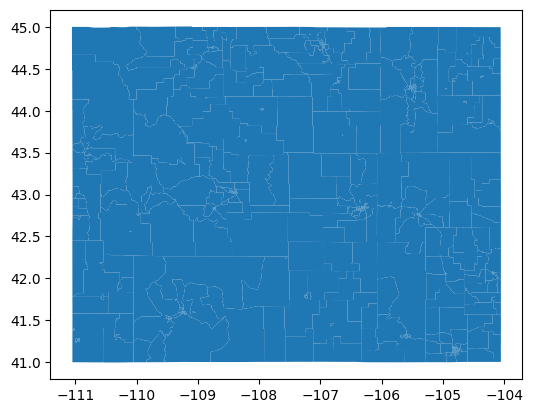

In [113]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()